In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
# Save the input and target variables
# print(diabetes_dataset.keys())
data = diabetes_dataset.data
target = diabetes_dataset.target

In [4]:
# Normalise the target data (this will make clearer training curves)
target = (target - target.mean(axis=0)) / target.std()

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, target, test_size=0.1)
print(train_data.shape)

(397, 10)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
                        Dense(128, activation='relu', input_shape=(train_data.shape[1], )),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(1)
    ])
    return model

model = get_model()

In [7]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, y=train_targets, epochs=10,
                    validation_split=0.15, batch_size=64)


Epoch 1/10
6/6 [==============================] - 0s 28ms/step - loss: 1.0146 - mae: 0.8647 - val_loss: 0.6366 - val_mae: 0.6678
Epoch 2/10
6/6 [==============================] - 0s 5ms/step - loss: 0.8989 - mae: 0.8203 - val_loss: 0.4931 - val_mae: 0.5953
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.6808 - mae: 0.7014 - val_loss: 0.5160 - val_mae: 0.5787
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.5784 - mae: 0.5970 - val_loss: 0.6824 - val_mae: 0.6764
Epoch 5/10
6/6 [==============================] - 0s 5ms/step - loss: 0.5446 - mae: 0.5925 - val_loss: 0.5478 - val_mae: 0.6119
Epoch 6/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4948 - mae: 0.5735 - val_loss: 0.5324 - val_mae: 0.5846
Epoch 7/10
6/6 [==============================] - 0s 6ms/step - loss: 0.4888 - mae: 0.5597 - val_loss: 0.5369 - val_mae: 0.6007
Epoch 8/10
6/6 [==============================] - 0s 5ms/step - loss: 0.4659 - mae: 0.5502 - val_loss: 

In [10]:
# Evaluate the model on the test set
model.evaluate(x=test_data, y=test_targets)


2/2 [==============================] - 0s 2ms/step - loss: 0.4257 - mae: 0.5137


[0.4256802797317505, 0.5137134194374084]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

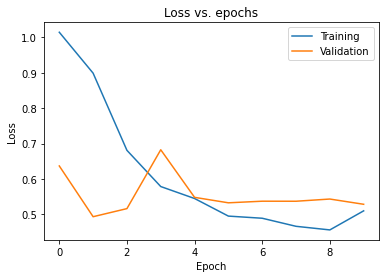

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate=rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate=rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate=rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate=rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate=rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate=rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-4, 0.6)

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(x=train_data, y=train_targets,
                 validation_split=0.15,
                 epochs=100,
                 batch_size=64)


Epoch 1/100
6/6 [==============================] - 0s 30ms/step - loss: 1.1032 - mae: 0.8739 - val_loss: 0.7585 - val_mae: 0.6914
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 1.1080 - mae: 0.8779 - val_loss: 0.7574 - val_mae: 0.6910
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0931 - mae: 0.8701 - val_loss: 0.7567 - val_mae: 0.6907
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1035 - mae: 0.8747 - val_loss: 0.7551 - val_mae: 0.6900
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 1.0965 - mae: 0.8717 - val_loss: 0.7549 - val_mae: 0.6904
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 1.1107 - mae: 0.8813 - val_loss: 0.7530 - val_mae: 0.6897
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0819 - mae: 0.8643 - val_loss: 0.7500 - val_mae: 0.6882
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 1.0890 - mae: 0.8676 - va

In [18]:
# Evaluate the model on the test set
model.evaluate(x=test_data, y=test_targets, verbose=2)


2/2 - 0s - loss: 0.6927 - mae: 0.6300


[0.6927343010902405, 0.629997730255127]

#### Plot the learning curves

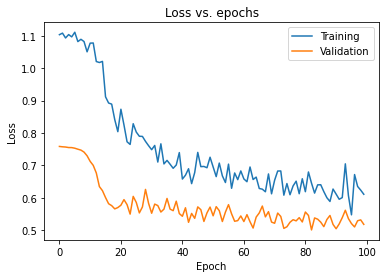

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):

    def on_train_begin(self, logs=None):
        print("Starting Training")

    def on_epoch_begin(self, epoch, logs=None):
        print("Starting Epoch: {}".format(epoch))

    def on_train_batch_begin(self, batch, logs=None):
        print("Training: Starting batch: {}".format(batch))

    def on_train_batch_end(self, batch, logs=None):
        print("Training: Finished batch: {}".format(batch))

    def on_epoch_end(self, epoch, log=None):
        print("Finished Epoch: {}".format(epoch))

    def on_train_end(self, logs=None):
        print("Finished Training")


class TestingCallback(Callback):

    def on_test_begin(self, logs=None):
        print("Starting Testing")

    def on_test_batch_begin(self, batch, logs=None):
        print("Testing: Starting batch: {}".format(batch))

    def on_test_batch_end(self, batch, logs=None):
        print("Testing: Finished batch: {}".format(batch))

    def on_test_end(self, logs=None):
        print("Finished Testing")


In [21]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation
model.fit(x=train_data, 
          y = train_targets, 
          callbacks=TrainingCallback(),
          epochs=3,
          batch_size=128,
          verbose=0)

Starting Training
Starting Epoch: 0
Training: Starting batch: 0
Training: Finished batch: 0
Training: Starting batch: 1
Training: Finished batch: 1
Training: Starting batch: 2
Training: Finished batch: 2
Training: Starting batch: 3
Training: Finished batch: 3
Finished Epoch: 0
Starting Epoch: 1
Training: Starting batch: 0
Training: Finished batch: 0
Training: Starting batch: 1
Training: Finished batch: 1
Training: Starting batch: 2
Training: Finished batch: 2
Training: Starting batch: 3
Training: Finished batch: 3
Finished Epoch: 1
Starting Epoch: 2
Training: Starting batch: 0
Training: Finished batch: 0
Training: Starting batch: 1
Training: Finished batch: 1
Training: Starting batch: 2
Training: Finished batch: 2
Training: Starting batch: 3
Training: Finished batch: 3
Finished Epoch: 2
Finished Training


In [24]:
# Evaluate the model
model.evaluate(x=test_data, 
               y=test_targets,
               callbacks=TestingCallback())

Starting Testing
Testing: Starting batch: 0
Testing: Finished batch: 0
1/2 [==============>...............] - ETA: 0s - loss: 0.7708Testing: Starting batch: 1
Testing: Finished batch: 1
Finished Testing
2/2 [==============================] - 0s 2ms/step - loss: 0.9892


0.9892018437385559

In [25]:
# Make predictions with the model



***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [37]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets,
                                        epochs=100, validation_split=0.15,
                                        batch_size=64, 
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/100
6/6 [==============================] - 0s 22ms/step - loss: 1.0271 - val_loss: 0.6626
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.9639 - val_loss: 0.5650
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.7863 - val_loss: 0.4693
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6126 - val_loss: 0.7695
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.5985 - val_loss: 0.5793


In [38]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 2ms/step - loss: 0.4919


0.49190080165863037

In [39]:
# Re-train the regularised model
regularized_model = get_regularised_model(1e-8, 0.2)
regularized_model.compile(optimizer='adam', loss='mse')
reg_history = regularized_model.fit(train_data, train_targets,
                                    epochs=100, validation_split=0.15, 
                                    batch_size=64, 
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/100
6/6 [==============================] - 0s 27ms/step - loss: 1.0321 - val_loss: 0.6802
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0139 - val_loss: 0.6344
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.9415 - val_loss: 0.5238
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 0.7848 - val_loss: 0.4737
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 0.6512 - val_loss: 0.5436
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6039 - val_loss: 0.4910


In [40]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 2ms/step - loss: 0.5313


0.5313023924827576

#### Plot the learning curves

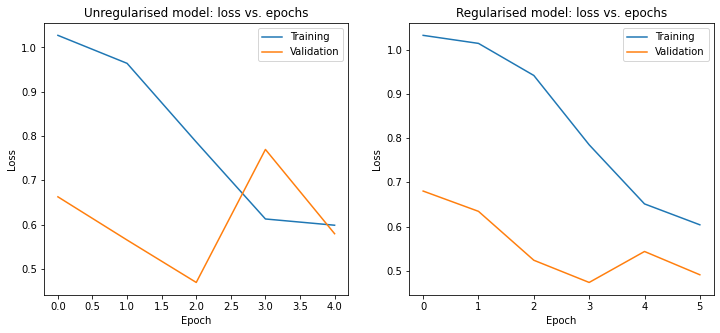

In [41]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()